In [1]:
import os
import cv2
import numpy as np
import torch
import yaml
from matplotlib import pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from internal.configs.dataset import SemanticColmapParams
from internal.dataparsers.semantic_colmap_dataparser import SemanticColmapDataParser
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.gsplat_renderer import GSPlatRenderer
from internal.semantic_splatting import SemanticSplatting

In [2]:
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint="../utils/sam_vit_h_4b8939.pth").to('cuda')
predictor = SamPredictor(sam)

In [3]:
dataparser_outputs = SemanticColmapDataParser(
    path=os.path.expanduser("~/data/TanksAndTemples/colmap/Truck/more_accurate/dense_max_1600"),
    output_path=os.getcwd(),
    global_rank=0,
    params=SemanticColmapParams(),
).get_outputs()

appearance group by camera id
loading colmap 3D points
[colmap dataparser] train set images: 251, val set images: 32, loaded mask: 0


In [4]:
load_from = "../outputs/Truck/semantic-gsplat/checkpoints/epoch=120-step=30000.ckpt"
ckpt = torch.load(load_from, map_location="cpu")


ckpt["hyper_parameters"]["initialize_from"] = "../" + ckpt["hyper_parameters"]["initialize_from"]
model = SemanticSplatting(**ckpt["hyper_parameters"])
model.setup("validate")
model.load_state_dict(ckpt["state_dict"])
model = model.to(device="cuda")
del ckpt

Pick an image

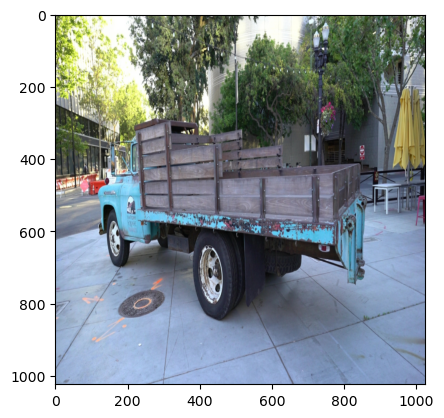

In [5]:
ref_img_camera_id = 0
mask_img_camera_id = 0

img = cv2.imread(dataparser_outputs.train_set.image_paths[ref_img_camera_id])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dsize=(1024, 1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
predictor.set_image(img)
sam_feature = predictor.features
H, W = sam_feature.shape[-2:]
plt.imshow(img)

Prompt segmentation

3


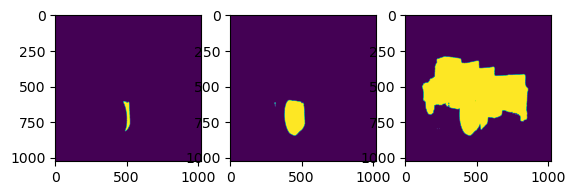

In [6]:
input_point = np.array([[500, 650]])
input_label = np.ones(len(input_point))

with torch.no_grad():
    vanilla_masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

print(len(vanilla_masks))

plt.subplot(1, 3, 1)
plt.imshow(vanilla_masks[0])
plt.subplot(1, 3, 2)
plt.imshow(vanilla_masks[1])
plt.subplot(1, 3, 3)
plt.imshow(vanilla_masks[2])

masks = torch.nn.functional.interpolate(
    torch.from_numpy(vanilla_masks).float().unsqueeze(0),
    (64, 64),
    mode='bilinear',
).squeeze(0).cuda()
masks[masks > 0.5] = 1
masks[masks != 1] = 0

In [7]:
picked_camera = dataparser_outputs.train_set.cameras[ref_img_camera_id].to_device("cuda")

In [8]:
nonlinear = model.sam_proj

In [9]:
# calculate the `average sam feature vector` of the `sam masked area`

mask_id = 2
origin_ref_mask = torch.tensor(vanilla_masks[mask_id]).float().cuda()

# resize mask to 64x64
if origin_ref_mask.shape != (64, 64):
    ref_mask = torch.nn.functional.interpolate(
        origin_ref_mask[None, None, :, :],
        (64, 64),
        mode='bilinear',
    ).squeeze().cuda()
    ref_mask[ref_mask > 0.5] = 1
    ref_mask[ref_mask != 1] = 0
else:
    ref_mask = origin_ref_mask

# map sam feature to a lower dimension
low_dim_features = nonlinear(
    sam_feature.view(-1, H * W).permute([1, 0])
).squeeze().permute([1, 0]).reshape([-1, H, W])

# set the features of pixel without mask to zero
mask_low_dim_features = ref_mask.unsqueeze(0) * torch.nn.functional.interpolate(
    low_dim_features.unsqueeze(0),
    ref_mask.shape[-2:],
    mode='bilinear',
).squeeze()
# calculate an average feature vector for mask area
mask_pooling_prototype = mask_low_dim_features.sum(dim=(1, 2)) / torch.count_nonzero(ref_mask)

In [10]:
def render_contrastive_feature(camera):
    camera = camera.to_device(model.device)
    return model(camera)

In [44]:
import kmeans_pytorch
import importlib
importlib.reload(kmeans_pytorch)
from kmeans_pytorch import kmeans

# render a feature map
rendered_feature = render_contrastive_feature(dataparser_outputs.train_set.cameras[0])['render']

## find those feature vectors closed to the average one
# multiply average feature vector `mask_pooling_prototype` with rendered one `rendered_feature`, then sum the vector for each pixel,
# the result is the cos(theta) of the rendered feature vector and the average one
similarity_mask = torch.einsum('C,CHW->HW', mask_pooling_prototype.cuda(), rendered_feature)
# resize to 64x64
similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(0).unsqueeze(0), (64,64), mode='bilinear').squeeze().cuda()
# mark those |theta| < 90 degrees with 1, else 0
similarity_mask[similarity_mask > 0] = 1
similarity_mask[similarity_mask != 1] = 0

# calculate the overlap ratio between the similarity_mask and ref_mask (the percent of the vector in masked area that closed to the average one)
iob = (similarity_mask * ref_mask).sum(dim = (-1, -2)) / ref_mask.sum()
print(f"iob={iob}")

if iob > 0.9:
    # use the average feature vector
    fmask_prototype = mask_pooling_prototype.unsqueeze(0)
else:
    # resize the mask and feature map (SAM), average the feature vectors again (again, means calculating averages in a larger range)
    downsampled_masks = torch.nn.functional.adaptive_avg_pool2d(ref_mask.unsqueeze(0).unsqueeze(0), (8,8)).squeeze()  # [H, W]
    downsampled_features = torch.nn.functional.adaptive_avg_pool2d(mask_low_dim_features.unsqueeze(0), (8,8)).squeeze(0)  # [N_features, H, W]
    # why need to be divided by `downsampled_masks`?
    downsampled_features /= downsampled_masks.unsqueeze(0)

    downsampled_masks[downsampled_masks != 0]= 1
    # pick vectors in resized 8x8 area
    # pick those downsampled_features of pixels with downsampled_masks != 0 (locating at masked pixel)
    init_prototypes = downsampled_features[:, downsampled_masks.bool()].permute([1,0])  # [N_pixels, N_features]

    # pick vectors in 64x64 area
    # pick those `low_dim_features` of pixels with `ref_mask is True` (feature vector located at masked pixel)
    masked_sam_features = low_dim_features[:, ref_mask.bool()]  # [N_features, N_pixels]
    masked_sam_features = masked_sam_features.permute([1,0])  # [N_pixels, N_features]

    # if pixel count of down sampled one <= 1
    num_clusters = init_prototypes.shape[0]
    print(num_clusters)
    if num_clusters <= 1:
        num_clusters = min(int(masked_sam_features.shape[0] ** 0.5), 32)
        init_prototypes = []

    # cluster `masked_sam_features` with `init_prototypes`, so as to adjust the `init_prototypes` to more suitable vectors `cluster_centers`
    cluster_ids_x, cluster_centers = kmeans(
        X=masked_sam_features, num_clusters=num_clusters, cluster_centers=init_prototypes, distance='cosine', device=torch.device('cuda')
    )

    ## find those feature vectors of the feature map closed to the adjusted centers (`cluster_centers`)
    # calculate the cos(theta) of cluster_centers and rendered_feature, then sigmoid them?
    similarity_mask = torch.sigmoid(torch.einsum('NC,CHW->NHW', cluster_centers.cuda(), rendered_feature))  # [N_centers, H, W]
    similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(1), (64,64), mode='bilinear').squeeze().cuda()  # [N_centers, H, W]
    # mark those with angle in specific range
    similarity_mask[similarity_mask >= 0.5] = 1
    similarity_mask[similarity_mask != 1] = 0
    similarity_mask = similarity_mask.squeeze()  #  [N_centers, H, W], squeeze() does not change anything here

    # ratio to similarity_mask (`number of similar vector`/`number of vector`) for each center
    ioa = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / (similarity_mask.sum(dim = (-1, -2)) + 1e-5)  # [N_centers]
    # ration to ref_mask
    iob = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / ref_mask.sum()

    ioa = ioa.squeeze()
    iob = iob.squeeze()
    cluster_mask = ioa > 0.75  # where 75% of the vectors closed to the center vector

    # NMS
    for i in range(len(cluster_mask)):
        if not cluster_mask[i]:
            continue

        for j in range(i+1, len(cluster_mask)):
            if not cluster_mask[j]:
                continue

            # `similarity_mask[j] * similarity_mask[i]` is the Intersection set,
            # `similarity_mask[j] + similarity_mask[i]` - `Intersection set` is the Union set,
            # here find `the Intersection set`/`the Union set` > 0.75 (IoU)
            if (similarity_mask[j] * similarity_mask[i]).sum() / ((similarity_mask[j] + similarity_mask[i]).sum() - (similarity_mask[j] * similarity_mask[i]).sum()) > 0.75:
                # if two centers are similar, set the min ioa one to False
                if ioa[i] > ioa[j]:
                    cluster_mask[j] = False
                else:
                    cluster_mask[i] = False
                    break  # skip i

    # concat all feature vectors
    fmask_prototype = torch.cat([mask_pooling_prototype.unsqueeze(0), cluster_centers[cluster_mask.cpu(), :].cuda()], dim = 0)

iob=0.9771547317504883


In [47]:
point_features = model.gaussian_semantic_features

In [63]:
mask_prototype = fmask_prototype
# calculate the cos(theta) between `Gaussian semantic feature vector` and `center vector(s)`
if mask_prototype.shape[0] == 1 or len(mask_prototype.shape) == 1:
    # if there is only one center vector
    point_logits = torch.einsum('NC,C->N', point_features, mask_prototype.squeeze())
    point_scores = torch.sigmoid(point_logits)
else:
    point_logits = torch.einsum('NC,LC->NL', point_features, mask_prototype)  # [N_gaussians, N_center_vectors]
    point_logits = point_logits.max(-1)[0]  # pick the max cos(theta) one (minimal angle value)
    point_scores = torch.sigmoid(point_logits)

# the cos(theta) between `rendered_feature` and `center vector(s)`
two_d_point_logits = torch.einsum('NC,CHW->NHW', mask_prototype.cuda(), rendered_feature).max(dim = 0)[0]
# resize
two_d_point_logits = torch.nn.functional.interpolate(two_d_point_logits.float()[None, None, ...], ref_mask.shape[-2:], mode='bilinear').squeeze().cuda()
# pick those distance values located at masked pixel
in_mask_logits = two_d_point_logits[ref_mask.bool()]

# Adjustable Threshold (distance threshold in cos)
thresh = max(max(in_mask_logits.mean() + in_mask_logits.std(), torch.topk(point_logits, int(point_logits.shape[0]*0.1))[0][-1]), 0)

# mark point closer than thresh
mask = point_logits > thresh
torch.save(mask, './test_mask.pt')
print(torch.count_nonzero(mask))

tensor(23785, device='cuda:0')


In [65]:
from internal.renderers.gsplat_renderer import GSPlatRenderer
def render_mask(filtered_mask, mask):
    gaussian_model = model.models.gaussian
    
    opacities = gaussian_model.get_opacity
    if filtered_mask is not None:
        new_opacity = opacities.detach().clone()
        new_opacity[filtered_mask, :] = -1.
        opacities = new_opacity
    
    return GSPlatRenderer.render(
        means3D=gaussian_model.get_xyz,
        opacities=opacities,
        scales=gaussian_model.get_scaling,
        rotations=gaussian_model.get_rotation,
        features=None,
        active_sh_degree=0,
        viewpoint_camera=picked_camera,
        bg_color=torch.zeros((mask.shape[-1],), dtype=torch.float, device=gaussian_model.get_xyz.device),
        colors_precomp=mask,
    )["render"][:1, ...]

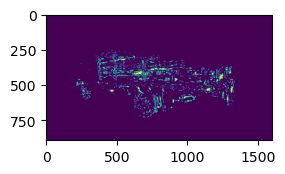

In [66]:
mask_img_camera_id = 0
rendered_mask = render_mask(None, mask.unsqueeze(-1).float())
plt.subplot(1,2,1)
plt.imshow(rendered_mask.squeeze().detach().cpu() >= 0.5)

In [52]:
import pytorch3d.ops
# remove outliers (>= mean+std)
def postprocess_statistical_filtering(pcd, precomputed_mask = None, max_time = 5):
    
    if type(pcd) == np.ndarray:
        pcd = torch.from_numpy(pcd).cuda()
    else:
        pcd = pcd.cuda()

    num_points = pcd.shape[0]
    # (N, P1, K)

    std_nearest_k_distance = 10
    
    print(f"pcd.shape={pcd.shape}")
    
    # remove outliers (>= mean+std)
    while std_nearest_k_distance > 0.1 and max_time > 0:
        nearest_k_distance = pytorch3d.ops.knn_points(
            pcd.unsqueeze(0),
            pcd.unsqueeze(0),
            K=int(num_points**0.5),
        ).dists  # [1, N_points, K_nearest_distance]
        mean_nearest_k_distance, std_nearest_k_distance = nearest_k_distance.mean(), nearest_k_distance.std()
        print(std_nearest_k_distance, "std_nearest_k_distance")

        mask = nearest_k_distance.mean(dim = -1) < mean_nearest_k_distance + std_nearest_k_distance

        mask = mask.squeeze()

        pcd = pcd[mask,:]
        if precomputed_mask is not None:
            precomputed_mask[precomputed_mask != 0] = mask
        max_time -= 1
        
    return pcd.squeeze(), nearest_k_distance.mean(), precomputed_mask

In [54]:
def postprocess_grad_based_statistical_filtering(pcd, precomputed_mask, gaussian_model, sam_mask):    
    grad_catch_mask = torch.zeros(gaussian_model.get_opacity.shape[0], 3, device = 'cuda')
    grad_catch_mask[precomputed_mask, :] = 1
    grad_catch_mask.requires_grad = True

    grad_catch_2dmask = render_mask(
        filtered_mask=~precomputed_mask,
        mask=grad_catch_mask,
    )
    
    print(grad_catch_2dmask.shape)

    target_mask = torch.tensor(sam_mask, device=grad_catch_2dmask.device)
    # resize to match grad_catch_2dmask
    target_mask = torch.nn.functional.interpolate(target_mask.unsqueeze(0).unsqueeze(0).float(), size=grad_catch_2dmask.shape[-2:] , mode='bilinear').squeeze(0).repeat([3,1,1])
    target_mask[target_mask > 0.5] = 1
    target_mask[target_mask != 1] = 0

    # 10*unmasked_pixel.sum() - masked_pixel.sum()
    loss = -(target_mask * grad_catch_2dmask).sum() + 10 * ((1-target_mask)* grad_catch_2dmask).sum()  # ?
    # in order to minimal the loss, either degrease unmasked_pixel (positive grad), or increase masked_pixel (negative grad)
    loss.backward()

    grad_score = grad_catch_mask.grad.mean(dim=-1)[precomputed_mask != 0].clone().squeeze()
    print(f"grad_score.shape={grad_score.shape}")
    grad_score = -grad_score
    
    pos_grad_score = grad_score.clone()
    pos_grad_score[pos_grad_score <= 0] = 0  # the unmasked pixel
    pos_grad_score[pos_grad_score <= pos_grad_score.mean() + pos_grad_score.std()] = 0  # remove outliers by the mean + std of gradient
    pos_grad_score[pos_grad_score != 0] = 1

    confirmed_mask = pos_grad_score.bool()
    
    print(f"postprocess_grad_based_statistical_filtering/pcd.shape={pcd.shape}")
    
    print(f"confirmed_mask.shape={confirmed_mask.shape}")

    if type(pcd) == np.ndarray:
        pcd = torch.from_numpy(pcd).cuda()
    else:
        pcd = pcd.cuda()

    confirmed_point = pcd[confirmed_mask == 1]
    
    print(f"confirmed_point.shape={confirmed_point.shape}")

    # remove outliers by knn again
    confirmed_point, _, _ = postprocess_statistical_filtering(confirmed_point, max_time=5)

    test_nearest_k_distance = pytorch3d.ops.knn_points(
        confirmed_point.unsqueeze(0),
        confirmed_point.unsqueeze(0),
        K=2,
    ).dists
    mean_nearest_k_distance, std_nearest_k_distance = test_nearest_k_distance[:,:,1:].mean(), test_nearest_k_distance[:,:,1:].std()
    test_threshold = torch.max(test_nearest_k_distance)
    print(test_threshold, "test threshold")

    # add more points from pcd back to confirmed_point, till their number_diff/confirmed_point < 0.001
    while True:

        nearest_k_distance = pytorch3d.ops.knn_points(
            pcd.unsqueeze(0),
            confirmed_point.unsqueeze(0),
            K=1,
        ).dists  # distance between pcd and confirmed_point
        mask = nearest_k_distance.mean(dim = -1) <= test_threshold
        mask = mask.squeeze()
        true_mask = mask
        if torch.abs(true_mask.count_nonzero() - confirmed_point.shape[0]) / confirmed_point.shape[0] < 0.001:
            break

        confirmed_point = pcd[true_mask,:]

    precomputed_mask[precomputed_mask == 1] = true_mask
        
    return confirmed_point.squeeze().detach().cpu().numpy(), precomputed_mask, test_threshold

In [55]:
xyz = model.models.gaussian.get_xyz
selected_xyz = xyz[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
# write_ply('./segmentation_res/vanilla_seg.ply', selected_xyz)

selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)

pcd.shape=torch.Size([23785, 3])
tensor(21.5590, device='cuda:0') std_nearest_k_distance


In [69]:
filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(
    pcd=selected_xyz.clone(), 
    precomputed_mask=mask_.clone(), 
    gaussian_model=model.models.gaussian,
    sam_mask=ref_mask.clone(), 
)
print(f"filtered_points.shape={filtered_points.shape}, filtered_mask.count_nonzero={filtered_mask.count_nonzero()}")

torch.Size([1, 892, 1600])
grad_score.shape=torch.Size([23767])
postprocess_grad_based_statistical_filtering/pcd.shape=torch.Size([23767, 3])
confirmed_mask.shape=torch.Size([23767])
confirmed_point.shape=torch.Size([1191, 3])
pcd.shape=torch.Size([1191, 3])
tensor(0.1291, device='cuda:0') std_nearest_k_distance
tensor(0.1353, device='cuda:0') std_nearest_k_distance
tensor(0.0637, device='cuda:0') std_nearest_k_distance
tensor(0.0533, device='cuda:0') test threshold
filtered_points.shape=(23531, 3), filtered_mask.count_nonzero=23531


/tmp/ipykernel_3242934/1889070234.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_mask = torch.tensor(sam_mask, device=grad_catch_2dmask.device)


In [57]:
def postprocess_growing(original_pcd, point_colors, seed_pcd, seed_point_colors, thresh = 0.05, grow_iter = 1):
    # bounding box of the selected points
    min_x, min_y, min_z = seed_pcd[:,0].min(), seed_pcd[:,1].min(), seed_pcd[:,2].min()
    max_x, max_y, max_z = seed_pcd[:,0].max(), seed_pcd[:,1].max(), seed_pcd[:,2].max()
    # bounding box size
    lx, ly, lz = max_x - min_x, max_y - min_y, max_z - min_z
    # enlarge a little bit
    min_x, min_y, min_z = min_x - lx*0.05, min_y - ly*0.05, min_z - lz*0.05
    max_x, max_y, max_z = max_x + lx*0.05, max_y + ly*0.05, max_z + lz*0.05

    # mask original points inside bounding box
    cutout_mask = (original_pcd[:,0] < max_x) * (original_pcd[:,1] < max_y) * (original_pcd[:,2] < max_z)
    cutout_mask *= (original_pcd[:,0] > min_x) * (original_pcd[:,1] > min_y) * (original_pcd[:,2] > min_z)
    
    cutout_point_cloud = original_pcd[cutout_mask > 0]

    for i in range(grow_iter):
        num_points_in_seed = seed_pcd.shape[0]
        # find distance between `cutout_point_cloud` and `seed_pcd` < `thresh`,
        # it means that those points closed to seed_pcd should be selected too, thought their feature vector not closed to the center one
        res = pytorch3d.ops.ball_query(
            cutout_point_cloud.unsqueeze(0), 
            seed_pcd.unsqueeze(0),
            K=1,
            radius=thresh,
            return_nn=False
        ).idx  # [1, N_cutout_point_cloud, K_idx]

        mask = (res != -1).sum(-1) != 0  # mark those points closed to any seed_pcd

        mask = mask.squeeze()  # [N_cutout_point_cloud]

        # update seed_pcd with new points
        seed_pcd = cutout_point_cloud[mask, :]
    
    # update mask
    final_mask = cutout_mask.clone()
    final_mask[final_mask != 0] = mask > 0

    print(mask.count_nonzero())

    return seed_pcd, final_mask, None

In [58]:
# find those points closed to `the selected points (with feature vector closed to center one)`
final_xyz, point_mask, final_normals = postprocess_growing(xyz, None, torch.from_numpy(filtered_points).cuda(), None, max(thresh, 0.05), grow_iter = 1)
torch.save(torch.logical_and(model.models.gaussian.get_opacity.squeeze() > 0.1, point_mask.bool()), './pre_final_mask.pt')

tensor(636033, device='cuda:0')


# Filter out the points confirmed to be negative

In [59]:
# remove those points contribute to pixel that not masked by SAM

final_mask = point_mask.float().detach().clone().unsqueeze(-1)
final_mask.requires_grad = True

background = torch.zeros(final_mask.shape[0], 3, device = 'cuda')
rendered_mask = render_mask(None, final_mask)

# print(rendered_mask_pkg['mask'].min(), rendered_mask_pkg['mask'].max())

# resize SAM mask to be the same as rendered_mask
tmp_target_mask = torch.tensor(origin_ref_mask, device=rendered_mask.device)
tmp_target_mask = torch.nn.functional.interpolate(tmp_target_mask.unsqueeze(0).unsqueeze(0).float(), size=rendered_mask.shape[-2:] , mode='bilinear').squeeze(0)
tmp_target_mask[tmp_target_mask > 0.5] = 1
tmp_target_mask[tmp_target_mask != 1] = 0

loss = 30*torch.pow(tmp_target_mask - rendered_mask, 2).sum()
# those pixel diff to the resized SAM mask, will have gradient; those not masked by SAM, have positive gradient
loss.backward()

grad_score = final_mask.grad.clone()
final_mask = final_mask - grad_score
final_mask[final_mask < 0] = 0  # not masked by SAM
final_mask[final_mask != 0] = 1
# update mask
final_mask *= point_mask.unsqueeze(-1)


torch.save(final_mask.bool(), './final_mask.pt')

final_xyz = xyz[final_mask.cpu().bool().squeeze(), ...].data

/tmp/ipykernel_3242934/407957451.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp_target_mask = torch.tensor(origin_ref_mask, device=rendered_mask.device)


In [67]:
final_mask.count_nonzero()

tensor(622810, device='cuda:0')

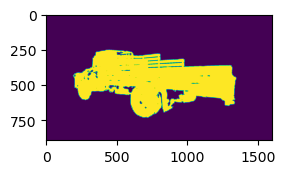

In [60]:
mask_img_camera_id = 0
rendered_mask = render_mask(None, final_mask.float())
plt.subplot(1,2,1)
plt.imshow(rendered_mask.squeeze().detach().cpu() >= 0.5)